<a href="https://colab.research.google.com/github/mvakhmenin/MindSet/blob/main/Mind_set_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D1%86%D0%B5%D0%BD_%D0%BD%D0%B0_%D0%B0%D1%80%D0%BC%D0%B0%D1%82%D1%83%D1%80%D1%83_(%D0%BF%D0%BE%D0%BB%D0%BD%D1%8B%D0%B9_%D0%BD%D0%B0%D0%B1%D0%BE%D1%80_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_sktime_%2B_%D0%BA%D1%80%D0%BE%D1%81%D1%81_%D0%B2%D0%B0%D0%BB%D0%B8%D0%B4%D0%B0%D1%86%D0%B8%D1%8F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Mind-set - Самолет - Прогноз цен на металл</h1>

In [ ]:
pip install yadisk # документация - https://yadisk.readthedocs.io/

     |████████████████████████████████| 48 kB 1.9 MB/s 


In [ ]:
pip install sktime

     |████████████████████████████████| 6.1 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 39.8 MB/s 
     |████████████████████████████████| 9.8 MB 37.5 MB/s 
     |████████████████████████████████| 26.3 MB 54.0 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.8.1 requires statsmodels>=0.12.1, but you have statsmodels 0.10.2 which is incompatible.


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.0 MB/s 
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.8.1 requires statsmodels<=0.12.1, but you have statsmodels 0.13.1 which is incompatible.


In [ ]:
pip install tbats

     |████████████████████████████████| 43 kB 678 kB/s 


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 50 kB/s 


In [ ]:
import yadisk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
import calendar
import datetime as dt

In [ ]:
try:
  df_init = pd.read_excel('арматура.xls', skiprows=8)
except:
  print('Файл не найден, скачиваю файл')
  ya = yadisk.YaDisk(token="xxxxx")

  # Check if the token is valid
  if ya.check_token():
    print('Токен работает')
  else: 
    print('Какая-то проблема с токеном, получаем новый токен')
    # Ниже указываются ID и Пароль, которые можно получить по ссылке https://oauth.yandex.ru/ 
    # для приложения: GoogleColab-YandexDisk
    ya = yadisk.YaDisk("805fcf6bb2ee4d35bae767e44044574e", "3c5eef2e166e4e16890b64a6ef3f337d")
    url = ya.get_code_url()

    print("Go to the following url: %s" % url)
    code = input("Enter the confirmation code: ")

    try:
      response = ya.get_token(code)
    except yadisk.exceptions.BadRequestError:
      print("Bad code")
      sys.exit(1)

    ya.token = response.access_token

    if ya.check_token():
      print("Sucessfully received token!")
    else:
      print("Something went wrong. Not sure how though...")

      # Скачиваем данные с Яндекс.диска
    files = ['арматура.xls']
    for f in files:
      print('Скачиваю файл', f)
      ya.download("Работа/mindset/цены/"+f, f)

    df_init = pd.read_excel('арматура.xls', skiprows=8)

<h2>Подготовка данных</h2>
Удаляем лишние столбцы, оставляем только ряд по Арматуре 10мм (в данной работе  будем анализировать только данный ряд). Переименовываем столбцы, разворачиваем таблицу, исправляем типы данных.

In [ ]:
df_init = pd.DataFrame(df_init.iloc[1,:]).T
df_init

In [ ]:
df_init.drop(inplace=True, columns=['Направление',
                                    'Описание', 
                                    'Страна', 
                                    'Регион',
                                    'Производитель', 
                                    'Страна-контрагент', 
                                    'Условия', 
                                    'Единица',	
                                    'Налоги', 
                                    'Пункт поставки',	
                                    'Контрактование'])
df_init.index = df_init['Продукция'] + ' ' + df_init['Сортамент']
df_metall = df_init.T.drop(index=['Продукция', 'Сортамент'])
df_metall.index = pd.to_datetime(df_metall.index, format='%d.%m.%Y')
df_metall.index = df_metall.index.to_period('W')
df_metall['Арматура 10 мм'] = pd.to_numeric(df_metall['Арматура 10 мм'])
df_metall

Провирим типы данных индекса и значений

In [ ]:
df_metall.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 200 entries, 2018-01-01/2018-01-07 to 2021-10-25/2021-10-31
Freq: W-SUN
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Арматура 10 мм  199 non-null    float64
dtypes: float64(1)
memory usage: 3.1 KB


Одно значение отсутствует. Найдем его

In [ ]:
df_metall[df_metall.isnull().any(axis=1)]

,Арматура 10 мм
2020-08-03/2020-08-09,NaN


Построим график исследуемого временного ряда.

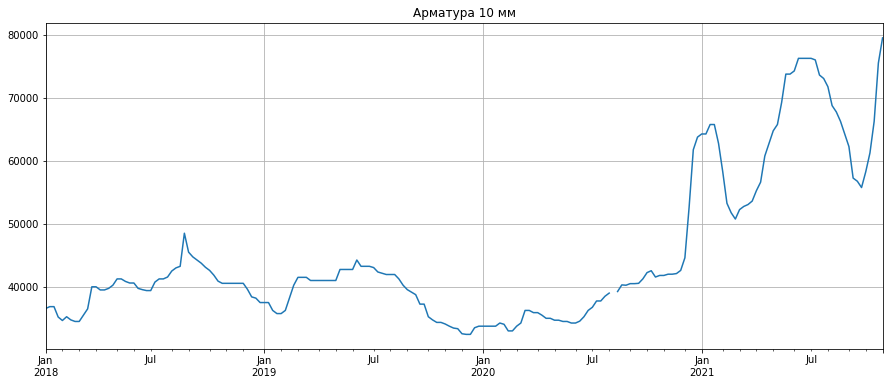

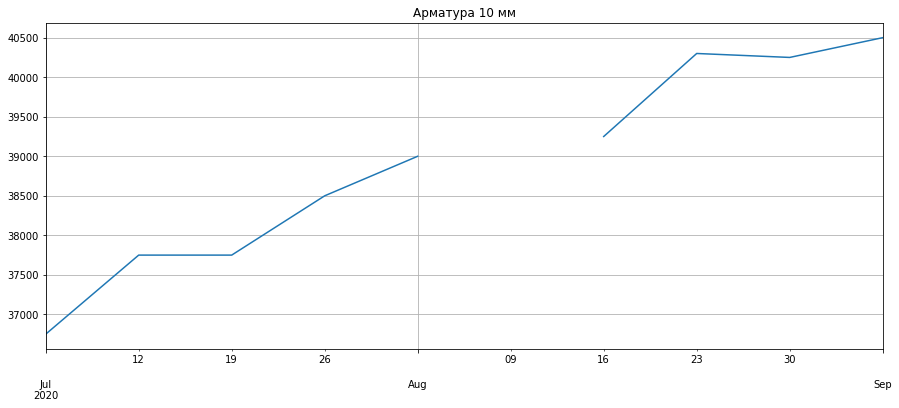

In [ ]:
df_metall['Арматура 10 мм'].plot(figsize=(15,6), grid=True, title=df_metall.columns[0])
plt.show()
df_metall['Арматура 10 мм'][130:-60].plot(figsize=(15,6), grid=True, title=df_metall.columns[0])
plt.show()
None

В составе библиотеки sktime есть класс Imputer для обработки пропущенных значений. При создании экземпляра класса указывается один из следующих методов заполнения пропущенных значений:

* “drift”: аналогично параметру drift/trend алгоритма предсказания sktime.PolynomialTrendForecaster()

* “linear”: линейная интерполяция (pd.Series.interpolate())

* “nearest”: ближайшее значение (by pd.Series.interpolate())

* “constant”: пропущенные значения заполняются постоянной величеной, определенной в параметре "value" при создании экзепляра класса

* “mean” : среднее (pd.Series.mean())

* “median” : медиана (pd.Series.median())

* “backfill” ot “bfill” : аналогично параметрам из pd.Series.fillna()

* “pad” or “ffill” : аналогично параметрам из pd.Series.fillna()

* “random” : случайная величина в диапазоне pd.Series.min() и .max()

* “forecaster” : использовать алгоритм предсказания sktime, определенный в параметре "forecaster" при создании экзепляра класса

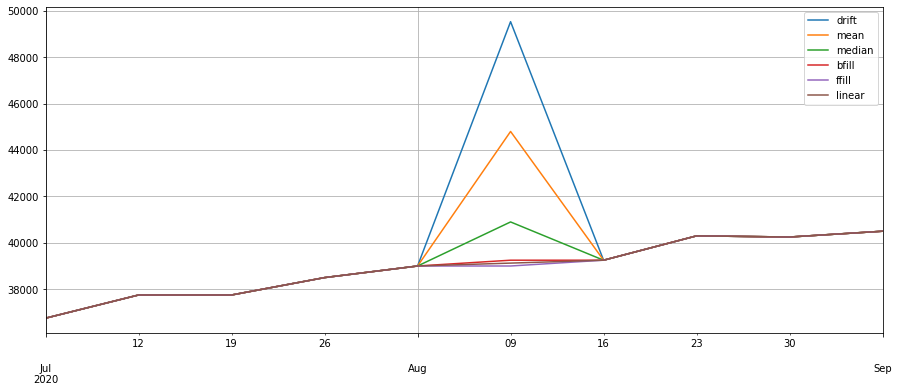

In [ ]:
from sktime.transformations.series.impute import Imputer

for method in ['drift', 'mean', 'median', 'bfill', 'ffill', 'linear']:
  transformer = Imputer(method=method)
  df_metall_imputed = transformer.fit_transform(df_metall['Арматура 10 мм'])
  df_metall_imputed[130:-60].plot(figsize=(15,6), grid=True, label=method)
plt.legend()
None

Метод nearest вызвал ошибку (при работе с Period и float), constant и random я не использовал из-за заведомо плохих результатов в рассматриваемом примере. Из рассмотренных методов наилучшие результаты дали 'linear', 'bfill', 'ffill'. Используем 'linear'

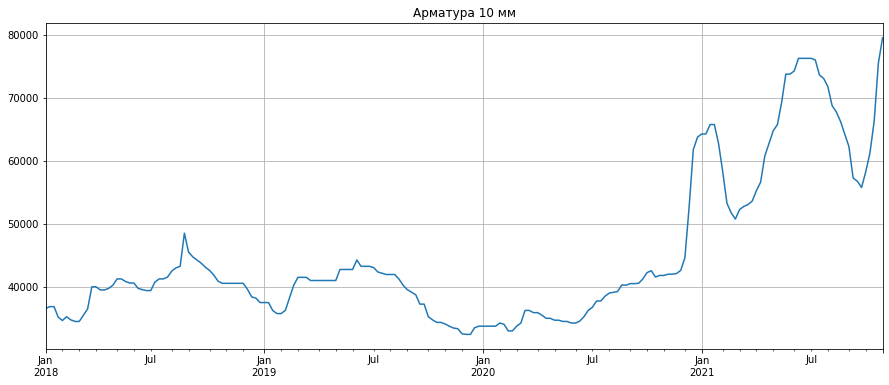

In [ ]:
df_metall_imputed.plot(figsize=(15,6), grid=True, title=df_metall_imputed.name)
None

Построим прогнозы с помощью моделей предсказания временных рядов (Экспоненциальное сглаживание, TBATS, ARIMA)

ExponentialSmoothing: MAE - 1164.69, MAPE - 1.72%
AutoETS: MAE - 861.15, MAPE - 1.27%
ThetaForecaster: MAE - 1227.47, MAPE - 1.81%
AutoARIMA: MAE - 315.76, MAPE - 0.47%
TBATS: MAE - 357.65, MAPE - 0.53%


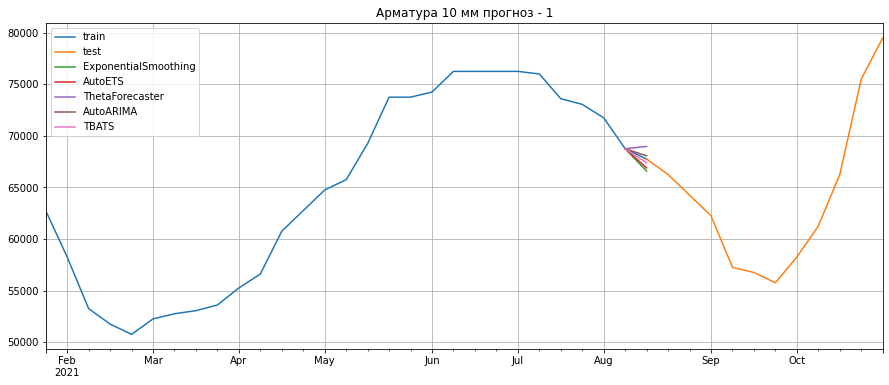

ExponentialSmoothing: MAE - 992.80, MAPE - 1.48%
AutoETS: MAE - 855.70, MAPE - 1.28%
ThetaForecaster: MAE - 2699.04, MAPE - 4.05%
AutoARIMA: MAE - 924.06, MAPE - 1.39%
TBATS: MAE - 445.25, MAPE - 0.67%


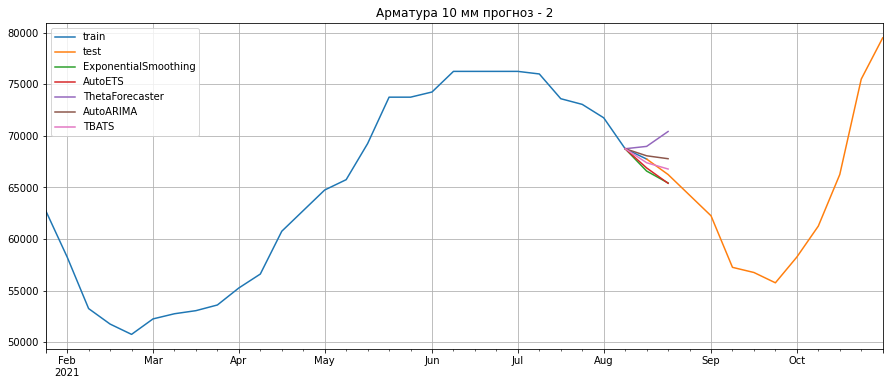

ExponentialSmoothing: MAE - 1010.67, MAPE - 1.56%
AutoETS: MAE - 689.60, MAPE - 1.06%
ThetaForecaster: MAE - 5571.19, MAPE - 8.72%
AutoARIMA: MAE - 2674.60, MAPE - 4.21%
TBATS: MAE - 1932.79, MAPE - 3.05%


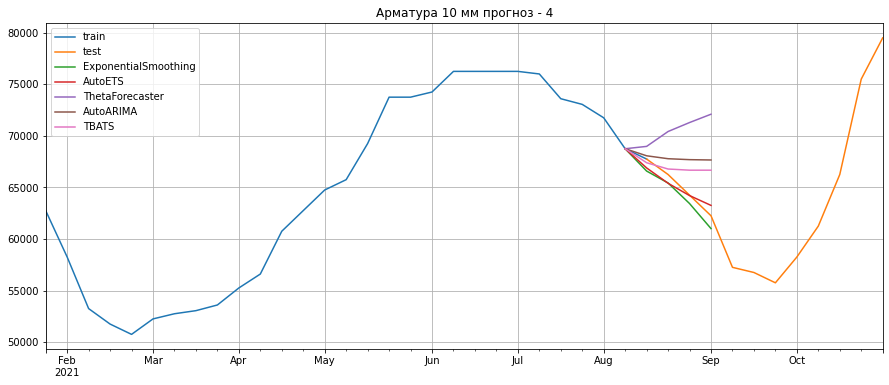

ExponentialSmoothing: MAE - 1987.22, MAPE - 3.36%
AutoETS: MAE - 2691.81, MAPE - 4.66%
ThetaForecaster: MAE - 9971.30, MAPE - 16.98%
AutoARIMA: MAE - 6659.50, MAPE - 11.46%
TBATS: MAE - 5801.56, MAPE - 10.02%


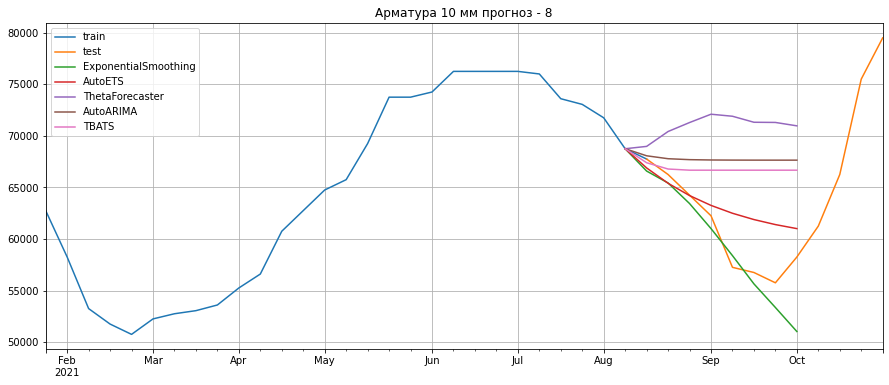

ExponentialSmoothing: MAE - 9727.46, MAPE - 13.79%
AutoETS: MAE - 5214.46, MAPE - 7.63%
ThetaForecaster: MAE - 9063.98, MAPE - 14.77%
AutoARIMA: MAE - 6731.34, MAPE - 10.79%
TBATS: MAE - 6159.37, MAPE - 9.79%


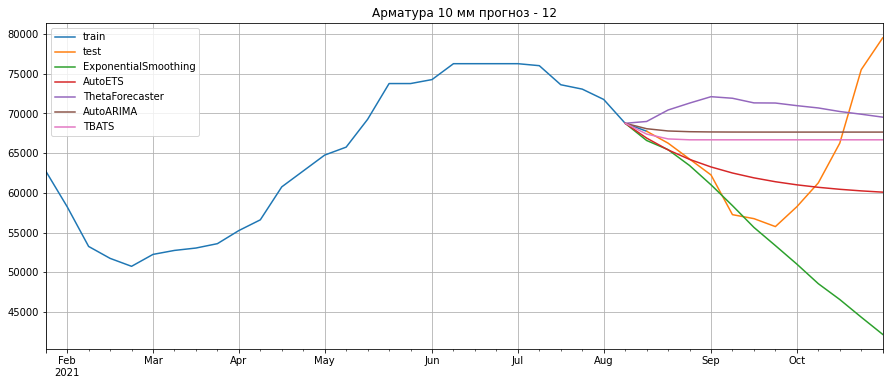

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.tbats import TBATS
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteError

result_name = []
result_fh = []
result_mae = []
result_mape = []

mae = MeanAbsoluteError()
mape = MeanAbsolutePercentageError(symmetric=False)

from warnings import filterwarnings
filterwarnings('ignore')

fhs = [np.arange(1, 1+1), 
       np.arange(1, 2+1), 
       np.arange(1, 4+1), 
       np.arange(1, 8+1), 
       np.arange(1, 12+1)]

models = {'ExponentialSmoothing': ExponentialSmoothing(trend='add', seasonal='add', sp=12), 
          'AutoETS': AutoETS(auto=True, sp=12), 
          'ThetaForecaster': ThetaForecaster(sp=12),
          'AutoARIMA': AutoARIMA(sp=12, suppress_warnings=True),
          'TBATS': TBATS(sp=12)}


for fh in fhs:
  df_metall_imputed[-40:-len(fhs[-1])+1].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='train')
  df_metall_imputed[-len(fhs[-1]):].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='test')
  for model_name in models:
    model = models[model_name]
    model.fit(df_metall_imputed[:-len(fhs[-1])])
    y_preds = model.predict(fh)
    pd.concat([df_metall_imputed[-len(fhs[-1])-1:-len(fhs[-1])], y_preds]).plot(figsize=(15,6), 
                                                                                grid=True, 
                                                                                label=model_name)
    if -len(fhs[-1])+len(fh) == 0:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):], y_preds)*100:.2f}%'
    else:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds)*100:.2f}%'
    print(f'{model_name}: MAE - {mae_score}, MAPE - {mape_score}')
    result_name.append(model_name)
    result_fh.append(len(fh))
    result_mae.append(mae_score)
    result_mape.append(mape_score)
  plt.legend()
  plt.show()

Построим прогнозы с помощью моделей машинного обучения (случайный лес, градиентный бустинг)

LGBMRegressor: MAE - 6399.10, MAPE - 9.45%
RandomForestRegressor: MAE - 901.50, MAPE - 1.33%
CatBoostRegressor: MAE - 332.23, MAPE - 0.49%


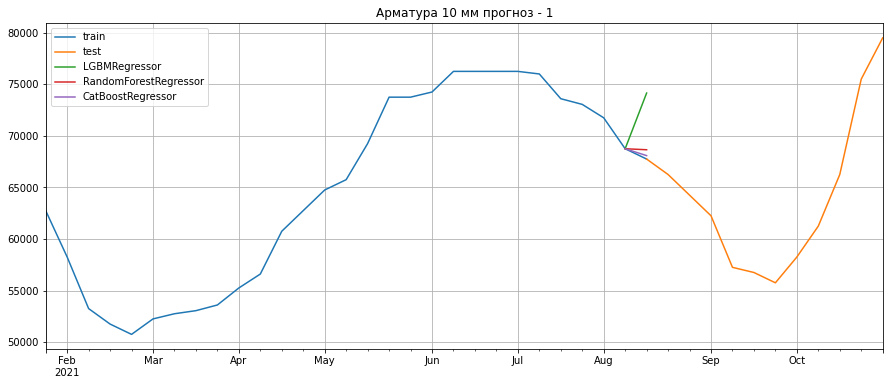

LGBMRegressor: MAE - 7149.10, MAPE - 10.68%
RandomForestRegressor: MAE - 1593.25, MAPE - 2.39%
CatBoostRegressor: MAE - 1000.45, MAPE - 1.50%


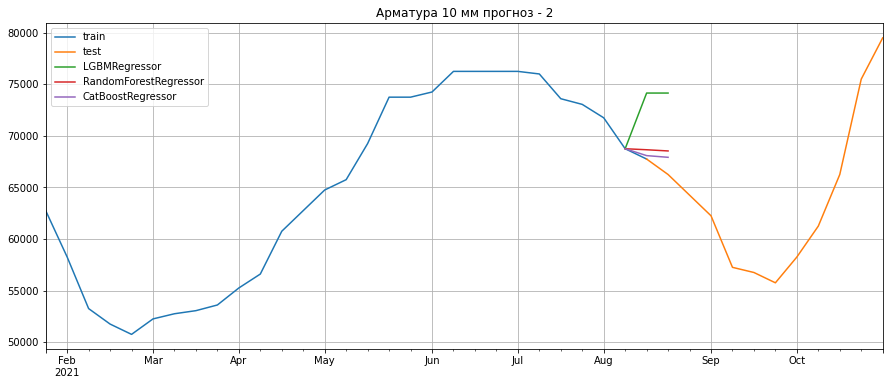

LGBMRegressor: MAE - 9024.10, MAPE - 13.97%
RandomForestRegressor: MAE - 3541.50, MAPE - 5.55%
CatBoostRegressor: MAE - 2948.28, MAPE - 4.64%


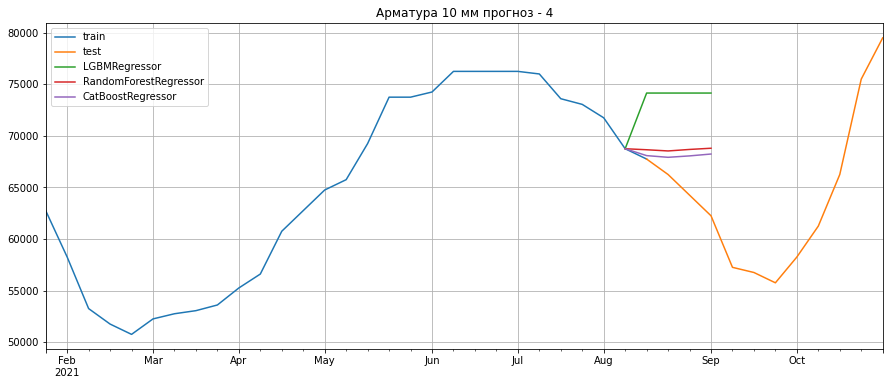

LGBMRegressor: MAE - 13086.60, MAPE - 22.05%
RandomForestRegressor: MAE - 8543.31, MAPE - 14.67%
CatBoostRegressor: MAE - 7433.98, MAPE - 12.79%


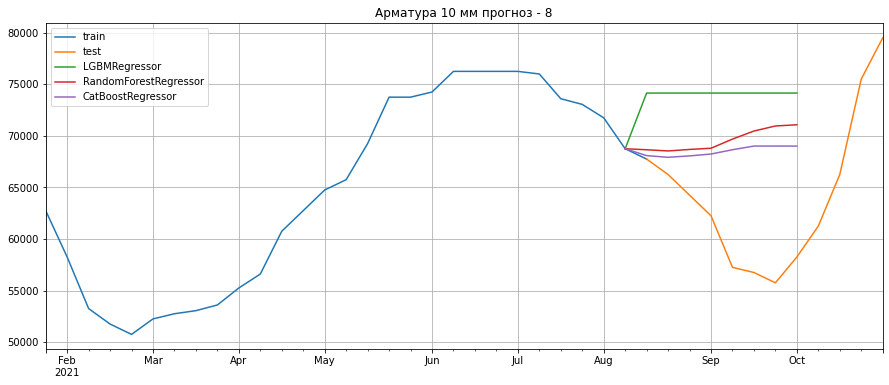

LGBMRegressor: MAE - 11016.07, MAPE - 18.16%
RandomForestRegressor: MAE - 7920.42, MAPE - 13.02%
CatBoostRegressor: MAE - 7181.31, MAPE - 11.66%


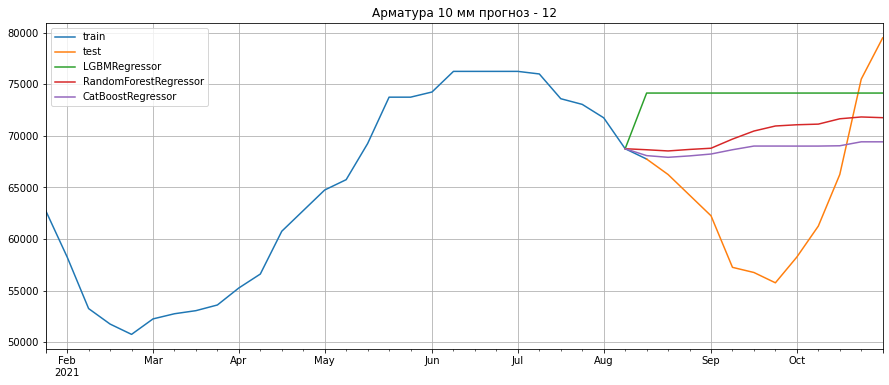

In [ ]:
from sktime.forecasting.compose import make_reduction
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost

models_ml = {'LGBMRegressor': make_reduction(LGBMRegressor(l2_leaf_reg = 3,
                                                                n_estimators=2000, 
                                                                learning_rate=0.05, 
                                                                depth=6), 
                                                  window_length=12, 
                                                  strategy="recursive"), 
                  'RandomForestRegressor': make_reduction(RandomForestRegressor(random_state=0), 
                                                          window_length=12, 
                                                          strategy="recursive"),
                  'CatBoostRegressor': make_reduction(catboost.CatBoostRegressor(l2_leaf_reg = 3, 
                                                                                 n_estimators=2000, 
                                                                                 learning_rate=0.05, 
                                                                                 depth=6,
                                                                                 silent=True), 
                                                      window_length=12, 
                                                      strategy="recursive",
                                                      scitype='tabular-regressor')}
for fh in fhs:
  df_metall_imputed[-40:-len(fhs[-1])+1].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='train')
  df_metall_imputed[-len(fhs[-1]):].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='test')
  for model_name in models_ml:
    model = models_ml[model_name]
    model.fit(df_metall_imputed[:-len(fhs[-1])])
    y_preds = model.predict(fh)
    pd.concat([df_metall_imputed[-len(fhs[-1])-1:-len(fhs[-1])], y_preds]).plot(figsize=(15,6), 
                                                                                grid=True, 
                                                                                label=model_name)
    if -len(fhs[-1])+len(fh) == 0:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):], y_preds)*100:.2f}%'
    else:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds)*100:.2f}%'
    print(f'{model_name}: MAE - {mae_score}, MAPE - {mape_score}')
    result_name.append(model_name)
    result_fh.append(len(fh))
    result_mae.append(mae_score)
    result_mape.append(mape_score)
  plt.legend()
  plt.show()

<h2>Тесты на стационарность</h2>

Попробуем улучшить точность прогноза моделей градиентного бустинга и случайного леса путем предварительного приведения временных рядов к стационарным.

Проверим ряды на стационраность с помощью расширенного теста Дики — Фуллера ADF (Augmented Dickey Fuller) и теста KPSS (Kwiatkowski-Phillips-Schmidt-Shin, Квятковский-Филлипс-Шмидт-Шин)

* **Расширенный тест Дики — Фуллера ADF (Augmented Dickey Fuller)** - один из самых популярных статистических тестов.<br>
Нулевая гипотеза: ряд имеет единичный корень, то есть не является стационарным (значение a = 1)<br>
Альтернативная гипотеза: ряд не имеет единичного корня, то есть является стационарным.<br>
Если нам не удастся отвергнуть нулевую гипотезу, мы можем сказать, что ряд нестационарный (значение статистики теста меньше критического значения, p-value стремится к 0). Это означает, что ряд может быть линейным или разностно-стационарным.

* **Тест KPSS (Kwiatkowski-Phillips-Schmidt-Shin, Квятковский-Филлипс-Шмидт-Шин)**.<br>
Нулевая гипотеза: стационарный процесс тренда.<br>
Альтернативная гипотеза: ряд имеет единичный корень (ряд не является стационарным).<br>

<h2>Типы стационарности</h2>

* **Строго стационарный**: строгий стационарный ряд удовлетворяет математическому 
определению стационарного процесса. Для строгого стационарного ряда среднее значение, дисперсия и ковариация не являются функцией времени. Цель состоит в том, чтобы преобразовать нестационарный ряд в строгий стационарный ряд для прогнозирования.
* **Стационарный тренд**: ряд, который не имеет единичного корня, но демонстрирует тренд, называется стационарным рядом тренда. После удаления трендовой составляющей, результирующий ряд будет строго стационарным. Тест KPSS классифицирует ряд как стационарный при отсутствии единичного корня. Это означает, что ряд может быть строго стационарным или стационарным по тренду.
* **Разностно-стационарный**: временной ряд, который можно сделать строгим стационарным с помощью разностей, попадает в категорию разностно-стационарных. Тест ADF также известен как тест разностной стационарности.

В результате выполнения тестов ADF и KPSS возможны следующие случаи:<br>
**Случай 1:** Оба теста показывают, что ряд не является стационарным -> ряд не является стационарным.<br>
**Случай 2:** Оба теста показывают, что ряд является стационарным -> ряд является стационарным<br>
**Случай 3:** KPSS = стационарный и ADF = не стационарный -> стационарный тренд, удалить тренд, чтобы сделать ряд строго стационарным.<br>
**Случай 4:** KPSS = не стационарный и ADF = стационарный -> разностно-стационарный, используйте разности, чтобы сделать ряд стационарным.<br>

In [ ]:
import statsmodels as sm

y = df_metall_imputed
adf = sm.tsa.stattools.adfuller(y)
print(f'Критерий Дикки-Фуллера: {adf[0]:.10f}')
print(f'p-value: {adf[1]:.10f}')
print(f'Критические значения {adf[4]}')
if adf[0] > adf[4]['1%']:
  print(f'Ряд не стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) больше критического значения 1% ({adf[4]["1%"]:.10f})')
else:
  print(f'Ряд стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) меньше критического значения 1% ({adf[4]["1%"]:.10f})')

print()
kpss = sm.tsa.stattools.kpss(y)
print(f'Критерий KPSS: {kpss[0]:.10f}')
print(f'p-value: {kpss[1]:.10f}')
print(f'Критические значения {kpss[3]}')
if kpss[0] > kpss[3]['10%']:
  print(f'Ряд не стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) больше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, отклоняем нулевую гипотезу о стационарности временного ряда")
else:
  print(f'Ряд стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) меньше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда")

Критерий Дикки-Фуллера: 1.0833229594
p-value: 0.9950717473
Критические значения {'1%': -3.4662005731940853, '5%': -2.8772932777920364, '10%': -2.575167750182615}
Ряд не стационарный, так как значение критерия Дикки-Фуллера (1.0833229594) больше критического значения 1% (-3.4662005732)

Критерий KPSS: 1.0940154009
p-value: 0.0100000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд не стационарный по KPSS, так как значение критерия KPSS (1.0940154009) больше критического значения 10% (0.3470000000)
Следовательно, отклоняем нулевую гипотезу о стационарности временного ряда


<p>Исходный временной ряд ожидаемо является не стационарным по результатам обоих тестов.</p>
<p>Применим первые разности к временному ряду для приведения его к стационарному.</p>

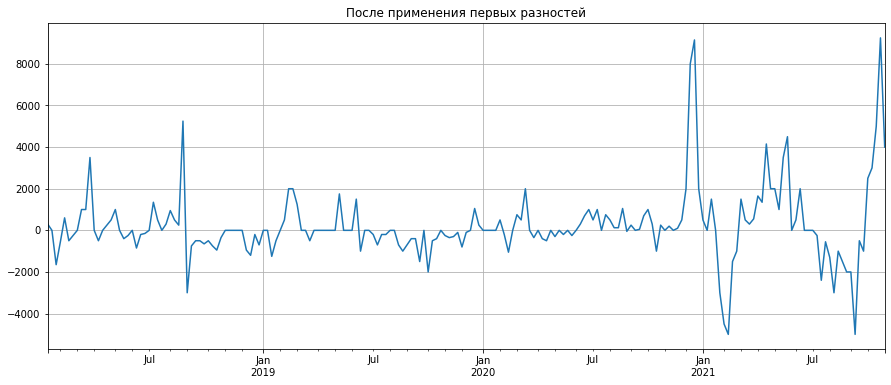

Критерий Дикки-Фуллера: -6.3771073839
p-value: 0.0000000227
Критические значения {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}
Ряд стационарный, так как значение критерия Дикки-Фуллера (-6.3771073839) меньше критического значения 1% (-3.4650587026)

Критерий KPSS: 0.1802469072
p-value: 0.1000000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарный по KPSS, так как значение критерия KPSS (0.1802469072) меньше критического значения 10% (0.3470000000)
Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда


In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.compose import TransformedTargetForecaster

model = TransformedTargetForecaster(steps=[
                                                  ("differencer", Differencer()),
                                                  ("forecaster", NaiveForecaster(strategy="drift"))
                                                  ]
                                          )
y_dif = model.fit_transform(y)
adf = sm.tsa.stattools.adfuller(y_dif)
y_dif.plot(figsize=(15,6), grid=True, title='После применения первых разностей')
plt.show()
print(f'Критерий Дикки-Фуллера: {adf[0]:.10f}')
print(f'p-value: {adf[1]:.10f}')
print(f'Критические значения {adf[4]}')
if adf[0] > adf[4]['1%']:
  print(f'Ряд не стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) больше критического значения 1% ({adf[4]["1%"]:.10f})')
else:
  print(f'Ряд стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) меньше критического значения 1% ({adf[4]["1%"]:.10f})')

print()
kpss = sm.tsa.stattools.kpss(y_dif)
print(f'Критерий KPSS: {kpss[0]:.10f}')
print(f'p-value: {kpss[1]:.10f}')
print(f'Критические значения {kpss[3]}')
if kpss[0] > kpss[3]['10%']:
  print(f'Ряд не стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) больше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, отклоняем нулевую гипотезу о стационарности временного ряда")
else:
  print(f'Ряд стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) меньше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда")

Модифицированный временной ряд стационарен в соответствии с результатами обоих тестов.

Визуально видно, что график первых разностей временного ряда после ноября 2020 года значительно меняет свой характер. Проверим на стационарность части временного ряда до ноября 2020 и после ноября 2020

Критерий Дикки-Фуллера: -7.0306874025
p-value: 0.0000000006
Критические значения {'1%': -3.4756368462466662, '5%': -2.8814104466172608, '10%': -2.5773652982553568}
Ряд стационарный, так как значение критерия Дикки-Фуллера (-7.0306874025) меньше критического значения 1% (-3.4756368462)

Критерий KPSS: 0.1096909772
p-value: 0.1000000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарный по KPSS, так как значение критерия KPSS (0.1096909772) меньше критического значения 10% (0.3470000000)
Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда


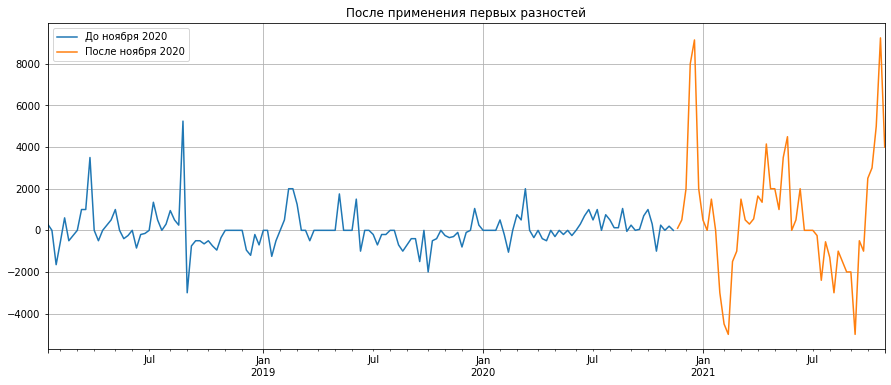

In [ ]:
y_dif1 = y_dif[:-50]
y_dif2 = y_dif[-50:]
y_dif1.plot(figsize=(15,6), grid=True, label='До ноября 2020', title='После применения первых разностей')
y_dif2.plot(figsize=(15,6), grid=True, label='После ноября 2020')
plt.legend()

adf = sm.tsa.stattools.adfuller(y_dif1)
print(f'Критерий Дикки-Фуллера: {adf[0]:.10f}')
print(f'p-value: {adf[1]:.10f}')
print(f'Критические значения {adf[4]}')
if adf[0] > adf[4]['1%']:
  print(f'Ряд не стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) больше критического значения 1% ({adf[4]["1%"]:.10f})')
else:
  print(f'Ряд стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) меньше критического значения 1% ({adf[4]["1%"]:.10f})')

print()
kpss = sm.tsa.stattools.kpss(y_dif1)
print(f'Критерий KPSS: {kpss[0]:.10f}')
print(f'p-value: {kpss[1]:.10f}')
print(f'Критические значения {kpss[3]}')
if kpss[0] > kpss[3]['10%']:
  print(f'Ряд не стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) больше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, отклоняем нулевую гипотезу о стационарности временного ряда")
else:
  print(f'Ряд стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) меньше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда")

In [ ]:
adf = sm.tsa.stattools.adfuller(y_dif2)
print(f'Критерий Дикки-Фуллера: {adf[0]:.10f}')
print(f'p-value: {adf[1]:.10f}')
print(f'Критические значения {adf[4]}')
if adf[0] > adf[4]['1%']:
  print(f'Ряд не стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) больше критического значения 1% ({adf[4]["1%"]:.10f})')
else:
  print(f'Ряд стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) меньше критического значения 1% ({adf[4]["1%"]:.10f})')

print()
kpss = sm.tsa.stattools.kpss(y_dif2)
print(f'Критерий KPSS: {kpss[0]:.10f}')
print(f'p-value: {kpss[1]:.10f}')
print(f'Критические значения {kpss[3]}')
if kpss[0] > kpss[3]['10%']:
  print(f'Ряд не стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) больше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, отклоняем нулевую гипотезу о стационарности временного ряда")
else:
  print(f'Ряд стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) меньше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда")

Критерий Дикки-Фуллера: -2.8726644527
p-value: 0.0486203423
Критические значения {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд не стационарный, так как значение критерия Дикки-Фуллера (-2.8726644527) больше критического значения 1% (-3.5714715250)

Критерий KPSS: 0.0895926836
p-value: 0.1000000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарный по KPSS, так как значение критерия KPSS (0.0895926836) меньше критического значения 10% (0.3470000000)
Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда


<p>Часть временного ряда до ноября 2020 ожидаемо стационарна по обоим тестам. Часть временного ряда после ноября 2020 года стационарна по тесту KPSS, но не стационарна по тесту Дикки-Фуллера. Соответственно, получаем случай 3 - необходимо удалить тренд, чтобы привести ряд к стационарному.</p>

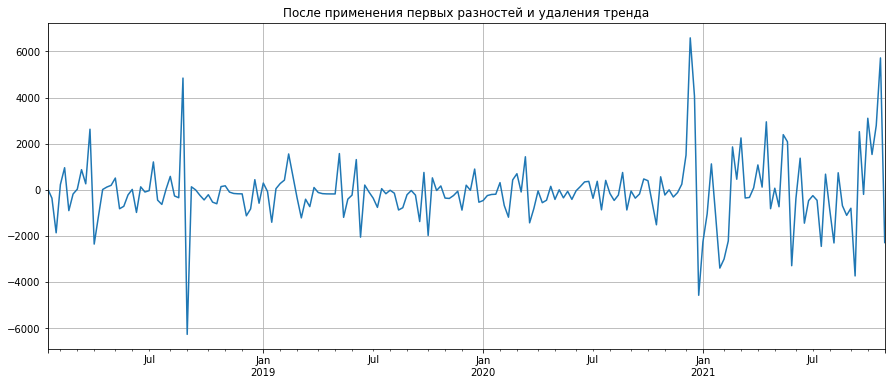

In [ ]:
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.boxcox import LogTransformer

model = TransformedTargetForecaster(steps=[
                                           ("differencer", Differencer()),
                                           ("detrender", Detrender(forecaster=TBATS())),
                                           ("forecaster", NaiveForecaster(strategy="drift"))
                                          ]
                                          )
y_dif_detrend = model.fit_transform(y)
y_dif_detrend.plot(figsize=(15,6), grid=True, title='После применения первых разностей и удаления тренда')
None

Критерий Дикки-Фуллера: -7.9876314061
p-value: 0.0000000000
Критические значения {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
Ряд стационарный, так как значение критерия Дикки-Фуллера (-7.9876314061) меньше критического значения 1% (-3.4765979175)

Критерий KPSS: 0.0742187684
p-value: 0.1000000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарный по KPSS, так как значение критерия KPSS (0.0742187684) меньше критического значения 10% (0.3470000000)
Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда


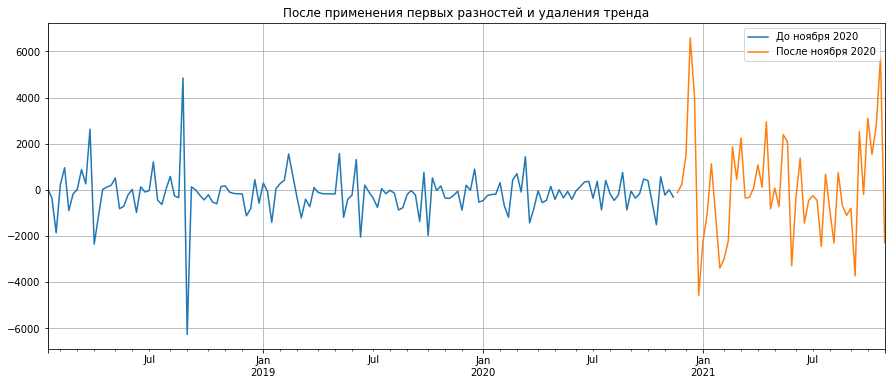

In [ ]:
y_dif_detrend1 = y_dif_detrend[:-50]
y_dif_detrend2 = y_dif_detrend[-50:]
y_dif_detrend1.plot(figsize=(15,6), grid=True, label='До ноября 2020', title='После применения первых разностей и удаления тренда')
y_dif_detrend2.plot(figsize=(15,6), grid=True, label='После ноября 2020')
plt.legend()

adf = sm.tsa.stattools.adfuller(y_dif_detrend1)
print(f'Критерий Дикки-Фуллера: {adf[0]:.10f}')
print(f'p-value: {adf[1]:.10f}')
print(f'Критические значения {adf[4]}')
if adf[0] > adf[4]['1%']:
  print(f'Ряд не стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) больше критического значения 1% ({adf[4]["1%"]:.10f})')
else:
  print(f'Ряд стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) меньше критического значения 1% ({adf[4]["1%"]:.10f})')

print()
kpss = sm.tsa.stattools.kpss(y_dif_detrend1)
print(f'Критерий KPSS: {kpss[0]:.10f}')
print(f'p-value: {kpss[1]:.10f}')
print(f'Критические значения {kpss[3]}')
if kpss[0] > kpss[3]['10%']:
  print(f'Ряд не стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) больше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, отклоняем нулевую гипотезу о стационарности временного ряда")
else:
  print(f'Ряд стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) меньше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда")

In [ ]:
adf = sm.tsa.stattools.adfuller(y_dif_detrend2)
print(f'Критерий Дикки-Фуллера: {adf[0]:.10f}')
print(f'p-value: {adf[1]:.10f}')
print(f'Критические значения {adf[4]}')
if adf[0] > adf[4]['1%']:
  print(f'Ряд не стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) больше критического значения 1% ({adf[4]["1%"]:.10f})')
else:
  print(f'Ряд стационарный, так как значение критерия Дикки-Фуллера ({adf[0]:.10f}) меньше критического значения 1% ({adf[4]["1%"]:.10f})')

print()
kpss = sm.tsa.stattools.kpss(y_dif_detrend2)
print(f'Критерий KPSS: {kpss[0]:.10f}')
print(f'p-value: {kpss[1]:.10f}')
print(f'Критические значения {kpss[3]}')
if kpss[0] > kpss[3]['10%']:
  print(f'Ряд не стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) больше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, отклоняем нулевую гипотезу о стационарности временного ряда")
else:
  print(f'Ряд стационарный по KPSS, так как значение критерия KPSS ({kpss[0]:.10f}) меньше критического значения 10% ({kpss[3]["10%"]:.10f})')
  print("Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда")

Критерий Дикки-Фуллера: -5.6638348590
p-value: 0.0000009249
Критические значения {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд стационарный, так как значение критерия Дикки-Фуллера (-5.6638348590) меньше критического значения 1% (-3.5714715250)

Критерий KPSS: 0.0804007614
p-value: 0.1000000000
Критические значения {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарный по KPSS, так как значение критерия KPSS (0.0804007614) меньше критического значения 10% (0.3470000000)
Следовательно, не отклоняем нулевую гипотезу о стационарности временного ряда


После применения первых разностей и удаления тренда обе части ряда стали стационарными в соответствии с обоими критериями. 

Построим прогнозы по стационарным временным рядам.

LGBMRegressor: MAE - 792.27, MAPE - 1.17%
RandomForestRegressor: MAE - 38.00, MAPE - 0.06%
CatBoostRegressor: MAE - 570.67, MAPE - 0.84%


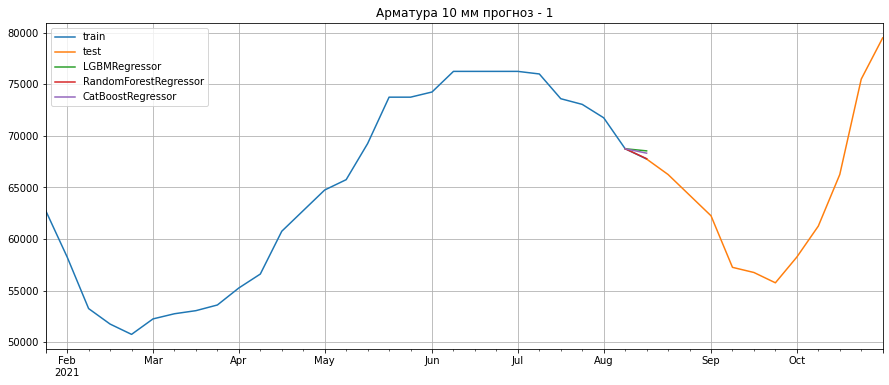

LGBMRegressor: MAE - 1144.57, MAPE - 1.71%
RandomForestRegressor: MAE - 482.25, MAPE - 0.73%
CatBoostRegressor: MAE - 1010.01, MAPE - 1.52%


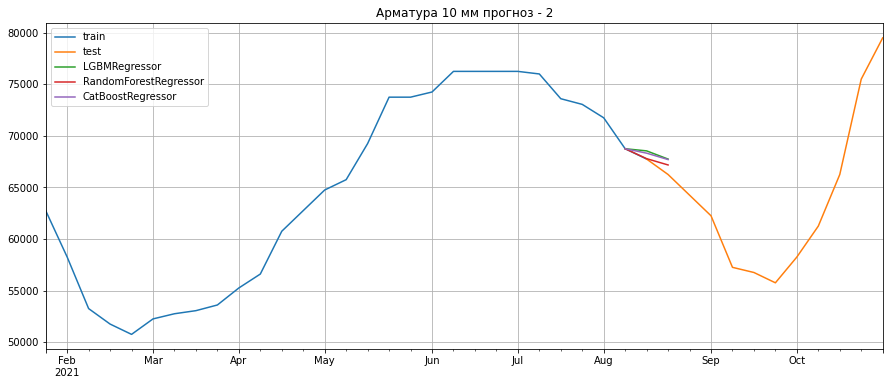

LGBMRegressor: MAE - 2519.78, MAPE - 3.95%
RandomForestRegressor: MAE - 1520.25, MAPE - 2.39%
CatBoostRegressor: MAE - 2405.41, MAPE - 3.77%


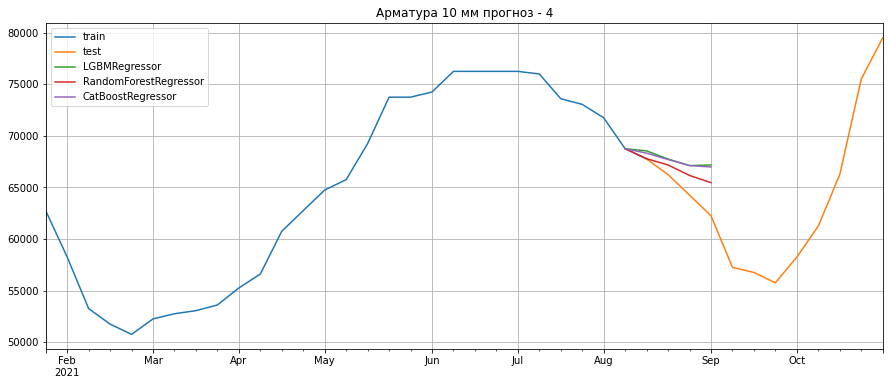

LGBMRegressor: MAE - 6492.00, MAPE - 11.17%
RandomForestRegressor: MAE - 4249.94, MAPE - 7.34%
CatBoostRegressor: MAE - 5784.09, MAPE - 9.94%


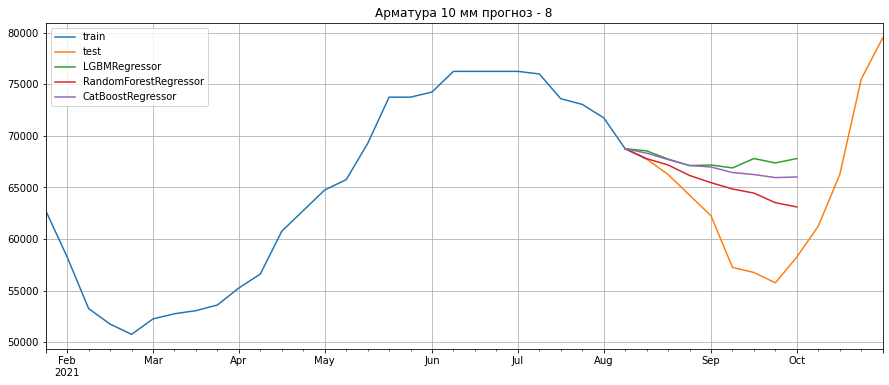

LGBMRegressor: MAE - 6196.44, MAPE - 10.12%
RandomForestRegressor: MAE - 5961.54, MAPE - 9.03%
CatBoostRegressor: MAE - 5749.97, MAPE - 9.23%


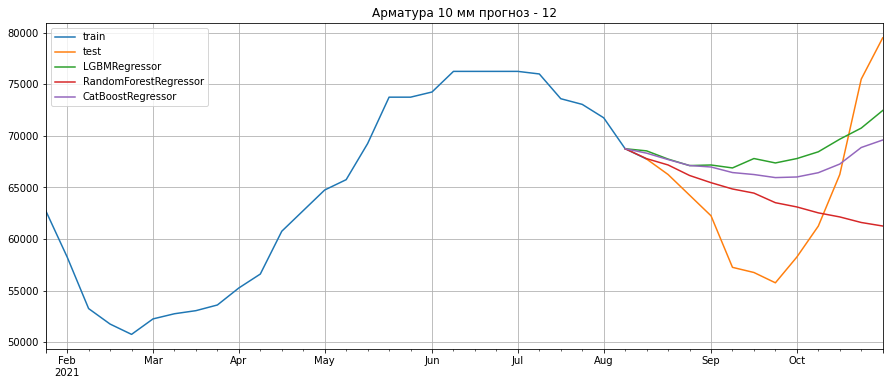

In [ ]:
for fh in fhs:
  df_metall_imputed[-40:-len(fhs[-1])+1].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='train')
  df_metall_imputed[-len(fhs[-1]):].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='test')
  for forecaster_name in models_ml:
    forecaster = models_ml[forecaster_name]
    model = TransformedTargetForecaster(steps=[("differencer", Differencer()),
                                               ("forecaster", forecaster)])
    model.fit(df_metall_imputed[:-len(fhs[-1])])
    y_preds = model.predict(fh)
    pd.concat([df_metall_imputed[-len(fhs[-1])-1:-len(fhs[-1])], y_preds]).plot(figsize=(15,6), 
                                                                                grid=True, 
                                                                                label=forecaster_name)
    if -len(fhs[-1])+len(fh) == 0:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):], y_preds)*100:.2f}%'
    else:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds)*100:.2f}%'
    print(f'{forecaster_name}: MAE - {mae_score}, MAPE - {mape_score}')
    result_name.append(f'{forecaster_name} diff1')
    result_fh.append(len(fh))
    result_mae.append(mae_score)
    result_mape.append(mape_score)
  plt.legend()
  plt.show()

LGBMRegressor: MAE - 823.60, MAPE - 1.22%
RandomForestRegressor: MAE - 312.20, MAPE - 0.46%
CatBoostRegressor: MAE - 674.88, MAPE - 1.00%


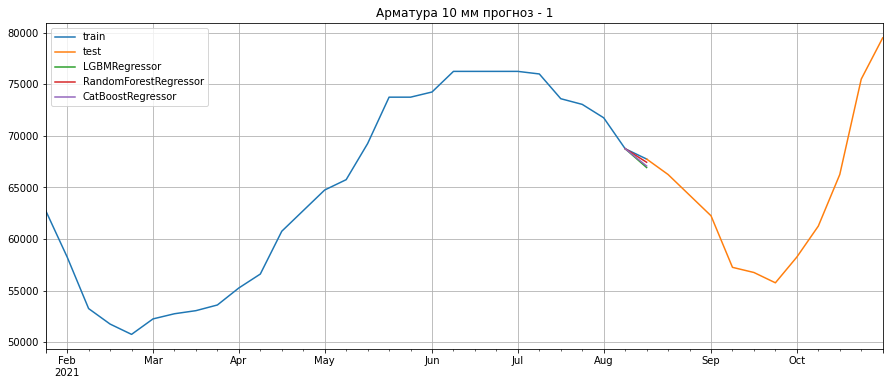

LGBMRegressor: MAE - 823.99, MAPE - 1.23%
RandomForestRegressor: MAE - 169.44, MAPE - 0.25%
CatBoostRegressor: MAE - 630.03, MAPE - 0.94%


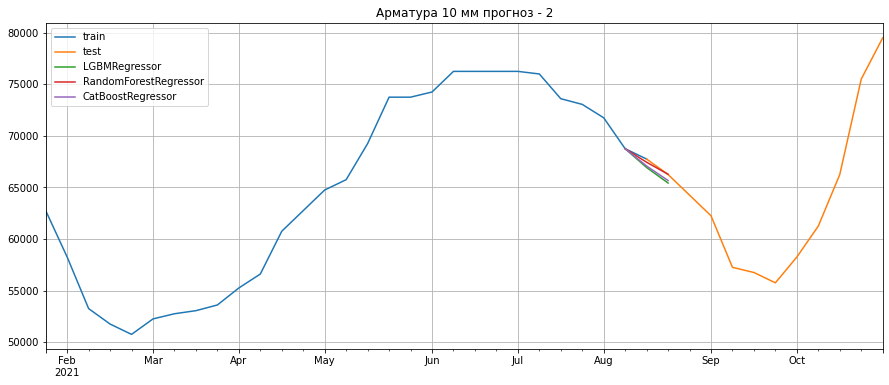

LGBMRegressor: MAE - 796.48, MAPE - 1.22%
RandomForestRegressor: MAE - 888.48, MAPE - 1.41%
CatBoostRegressor: MAE - 751.42, MAPE - 1.17%


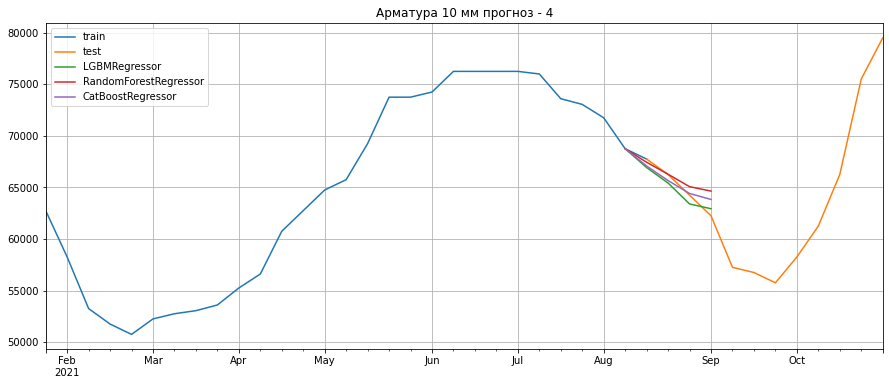

LGBMRegressor: MAE - 3009.96, MAPE - 5.20%
RandomForestRegressor: MAE - 4135.53, MAPE - 7.19%
CatBoostRegressor: MAE - 3373.75, MAPE - 5.86%


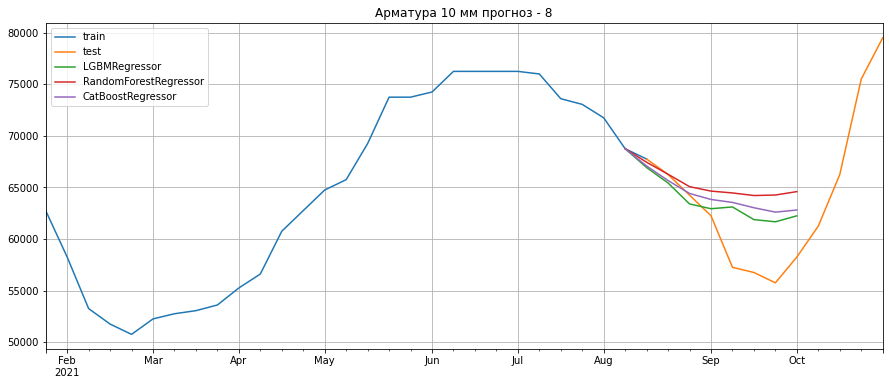

LGBMRegressor: MAE - 5022.20, MAPE - 7.45%
RandomForestRegressor: MAE - 5302.61, MAPE - 8.19%
CatBoostRegressor: MAE - 4962.29, MAPE - 7.50%


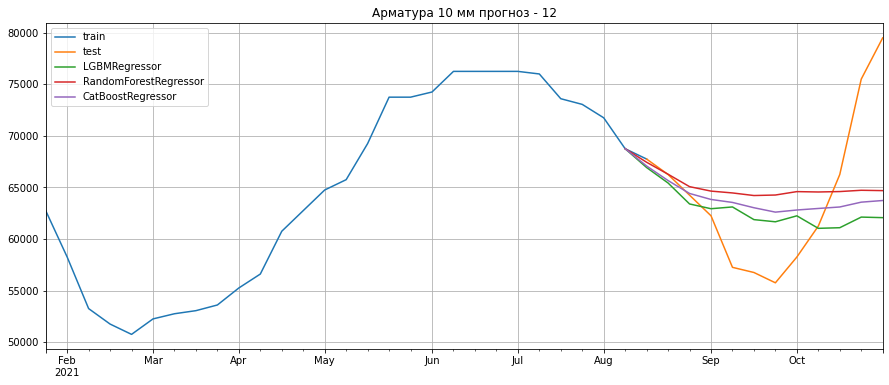

In [ ]:
for fh in fhs:
  df_metall_imputed[-40:-len(fhs[-1])+1].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='train')
  df_metall_imputed[-len(fhs[-1]):].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='test')
  for forecaster_name in models_ml:
    forecaster = models_ml[forecaster_name]
    model = TransformedTargetForecaster(steps=[("differencer", Differencer()),
                                               ("detrender", Detrender(forecaster=TBATS())),
                                               ("forecaster", forecaster)])
    model.fit(df_metall_imputed[:-len(fhs[-1])])
    y_preds = model.predict(fh)
    pd.concat([df_metall_imputed[-len(fhs[-1])-1:-len(fhs[-1])], y_preds]).plot(figsize=(15,6), 
                                                                                grid=True, 
                                                                                label=forecaster_name)
    if -len(fhs[-1])+len(fh) == 0:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):], y_preds)*100:.2f}%'
    else:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds)*100:.2f}%'
    print(f'{forecaster_name}: MAE - {mae_score}, MAPE - {mape_score}')
    result_name.append(f'{forecaster_name} diff1-detrend')
    result_fh.append(len(fh))
    result_mae.append(mae_score)
    result_mape.append(mape_score)
  plt.legend()
  plt.show()

LinearRegression: MAE - 350.40, MAPE - 0.52%
Ridge: MAE - 350.40, MAPE - 0.52%
Lasso: MAE - 368.98, MAPE - 0.54%
ElasticNet: MAE - 329.40, MAPE - 0.49%


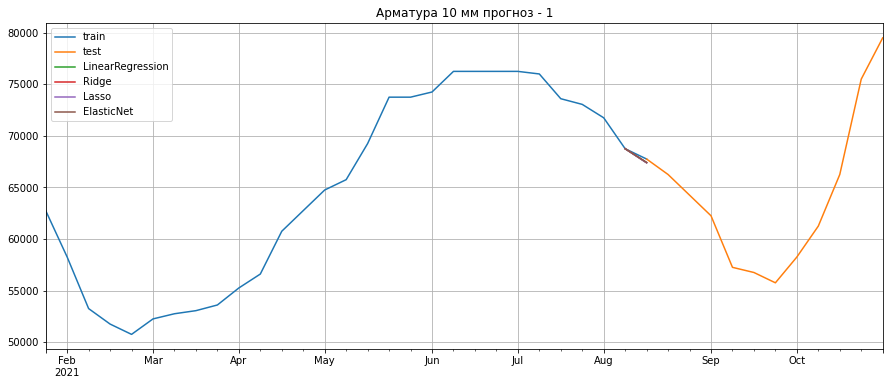

LinearRegression: MAE - 625.23, MAPE - 0.94%
Ridge: MAE - 625.23, MAPE - 0.94%
Lasso: MAE - 619.44, MAPE - 0.93%
ElasticNet: MAE - 599.32, MAPE - 0.90%


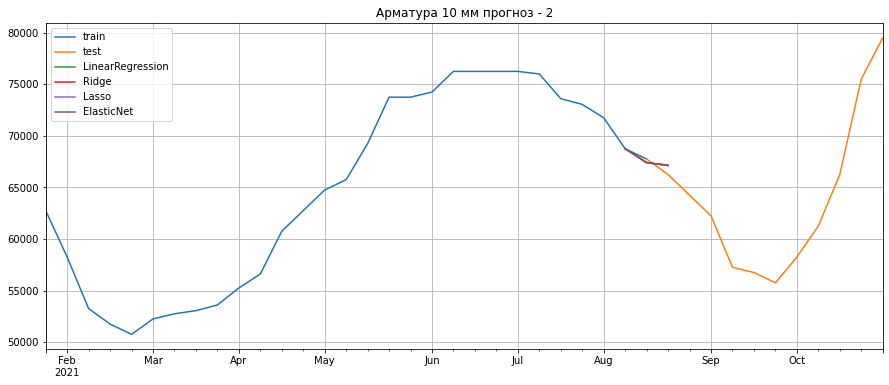

LinearRegression: MAE - 2277.71, MAPE - 3.59%
Ridge: MAE - 2277.71, MAPE - 3.59%
Lasso: MAE - 2265.32, MAPE - 3.57%
ElasticNet: MAE - 2251.83, MAPE - 3.55%


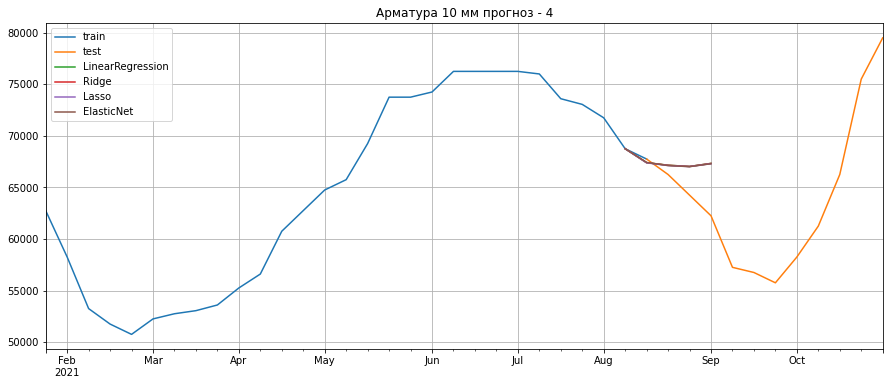

LinearRegression: MAE - 7557.85, MAPE - 13.07%
Ridge: MAE - 7557.85, MAPE - 13.07%
Lasso: MAE - 7538.65, MAPE - 13.03%
ElasticNet: MAE - 7495.11, MAPE - 12.96%


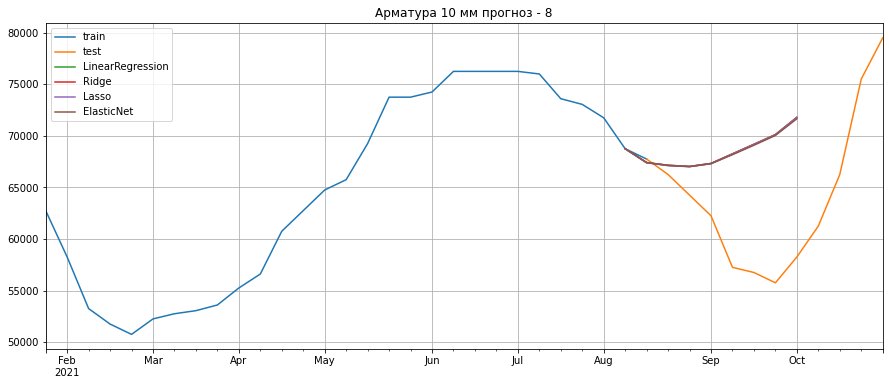

LinearRegression: MAE - 7073.11, MAPE - 11.81%
Ridge: MAE - 7073.11, MAPE - 11.81%
Lasso: MAE - 7060.19, MAPE - 11.79%
ElasticNet: MAE - 7038.46, MAPE - 11.74%


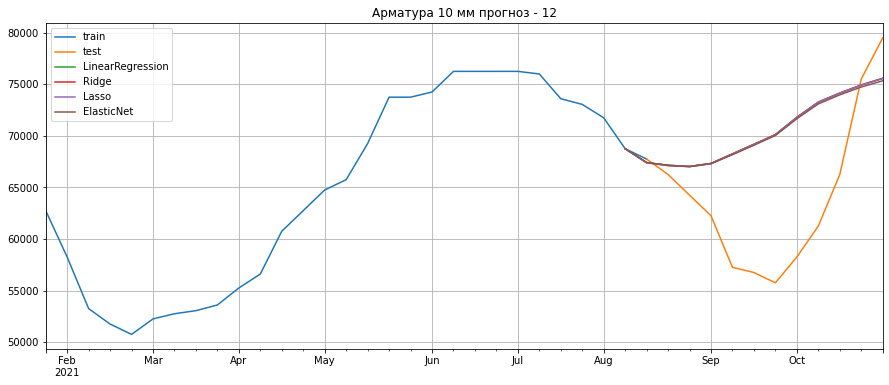

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


models_linear = {'LinearRegression': make_reduction(LinearRegression(), 
                                                    window_length=12, 
                                                    strategy="recursive"
                                                    ),
                 'Ridge': make_reduction(Ridge(random_state=0, alpha=5.0), 
                                         window_length=12, 
                                         strategy="recursive"
                                         ),
                 'Lasso': make_reduction(Lasso(random_state=0, alpha=25.0), 
                                         window_length=12, 
                                         strategy="recursive"
                                         ), 
                 'ElasticNet': make_reduction(ElasticNet(random_state=0, alpha=10000.0), 
                                              window_length=12, 
                                              strategy="recursive"
                                              )
                  }



for fh in fhs:
  df_metall_imputed[-40:-len(fhs[-1])+1].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='train')
  df_metall_imputed[-len(fhs[-1]):].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='test')
  for model_name in models_linear:
    model = models_linear[model_name]
    model.fit(df_metall_imputed[:-len(fhs[-1])])
    y_preds = model.predict(fh)
    pd.concat([df_metall_imputed[-len(fhs[-1])-1:-len(fhs[-1])], y_preds]).plot(figsize=(15,6), 
                                                                                grid=True, 
                                                                                label=model_name)
    if -len(fhs[-1])+len(fh) == 0:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):], y_preds)*100:.2f}%'
    else:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds)*100:.2f}%'
    print(f'{model_name}: MAE - {mae_score}, MAPE - {mape_score}')
    result_name.append(model_name)
    result_fh.append(len(fh))
    result_mae.append(mae_score)
    result_mape.append(mape_score)
  plt.legend()
  plt.show()

LinearRegression: MAE - 353.98, MAPE - 0.52%
Ridge: MAE - 353.98, MAPE - 0.52%
Lasso: MAE - 354.01, MAPE - 0.52%
ElasticNet: MAE - 363.02, MAPE - 0.54%


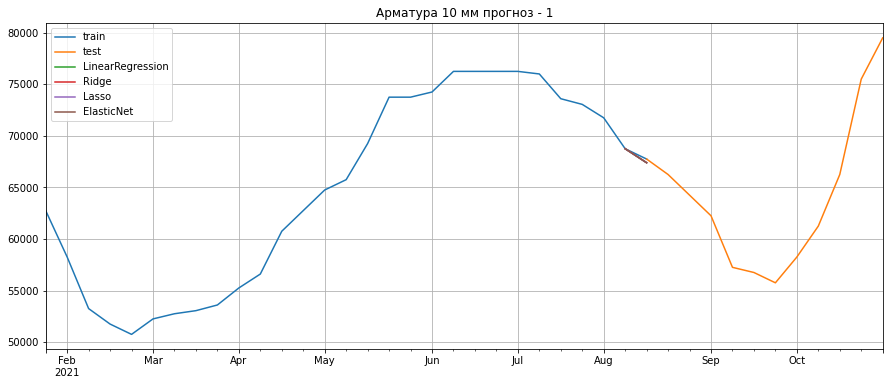

LinearRegression: MAE - 543.55, MAPE - 0.81%
Ridge: MAE - 543.55, MAPE - 0.81%
Lasso: MAE - 543.50, MAPE - 0.81%
ElasticNet: MAE - 536.99, MAPE - 0.80%


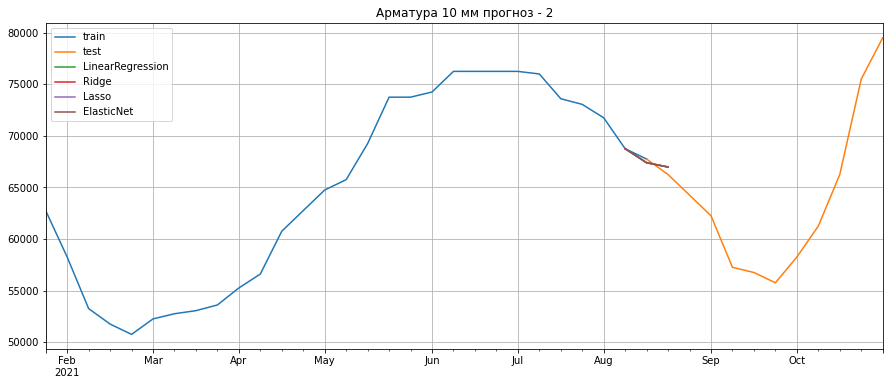

LinearRegression: MAE - 1967.78, MAPE - 3.10%
Ridge: MAE - 1967.78, MAPE - 3.10%
Lasso: MAE - 1967.75, MAPE - 3.10%
ElasticNet: MAE - 1966.77, MAPE - 3.10%


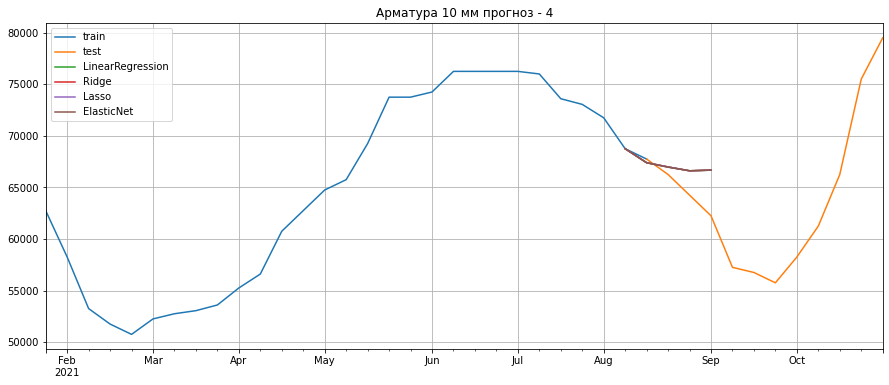

LinearRegression: MAE - 6728.40, MAPE - 11.64%
Ridge: MAE - 6728.40, MAPE - 11.64%
Lasso: MAE - 6728.36, MAPE - 11.64%
ElasticNet: MAE - 6730.82, MAPE - 11.64%


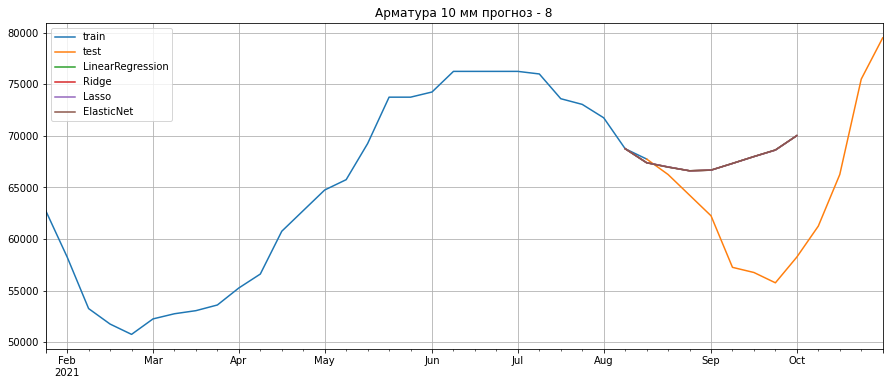

LinearRegression: MAE - 6600.81, MAPE - 10.86%
Ridge: MAE - 6600.81, MAPE - 10.86%
Lasso: MAE - 6600.79, MAPE - 10.86%
ElasticNet: MAE - 6603.75, MAPE - 10.87%


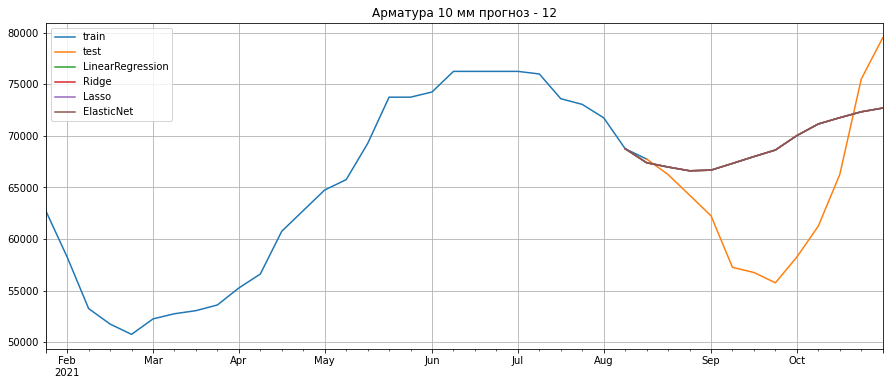

In [ ]:
for fh in fhs:
  df_metall_imputed[-40:-len(fhs[-1])+1].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='train')
  df_metall_imputed[-len(fhs[-1]):].plot(figsize=(15,6), 
                                         grid=True, 
                                         title=f'{df_metall_imputed.name} прогноз - {len(fh)}', 
                                         label='test')
  for forecaster_name in models_linear:
    forecaster = models_linear[forecaster_name]
    model = TransformedTargetForecaster(steps=[("differencer", Differencer()),
                                               ("forecaster", forecaster)])
    model.fit(df_metall_imputed[:-len(fhs[-1])])
    y_preds = model.predict(fh)
    pd.concat([df_metall_imputed[-len(fhs[-1])-1:-len(fhs[-1])], y_preds]).plot(figsize=(15,6), 
                                                                                grid=True, 
                                                                                label=forecaster_name)
    if -len(fhs[-1])+len(fh) == 0:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):], y_preds)*100:.2f}%'
    else:
      mae_score = f'{mae(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds):.2f}'
      mape_score = f'{mape(df_metall_imputed[-len(fhs[-1]):-len(fhs[-1])+len(fh)], y_preds)*100:.2f}%'
    print(f'{forecaster_name}: MAE - {mae_score}, MAPE - {mape_score}')
    result_name.append(f'{forecaster_name} diff1')
    result_fh.append(len(fh))
    result_mae.append(mae_score)
    result_mape.append(mape_score)
  plt.legend()
  plt.show()

In [ ]:
result_df = pd.DataFrame()
result_df['Алгоритм'] = result_name
result_df['Горизонт'] = result_fh
result_df['MAE'] = result_mae
result_df['MAPE'] = result_mape
pd.pivot_table(result_df,
               index=["Алгоритм"],
               values=["MAPE"],
               columns=['Горизонт'],
               aggfunc='sum')

MAPE                                
Горизонт                                1       2       4       8       12
Алгоритм                                                                  
AutoARIMA                            0.47%   1.39%   4.21%  11.46%  10.79%
AutoETS                              1.27%   1.28%   1.06%   4.66%   7.63%
CatBoostRegressor                    0.49%   1.50%   4.64%  12.79%  11.66%
CatBoostRegressor diff1              0.84%   1.52%   3.77%   9.94%   9.23%
CatBoostRegressor diff1-detrend      1.00%   0.94%   1.17%   5.86%   7.50%
ElasticNet                           0.49%   0.90%   3.55%  12.96%  11.74%
ElasticNet diff1                     0.54%   0.80%   3.10%  11.64%  10.87%
ExponentialSmoothing                 1.72%   1.48%   1.56%   3.36%  13.79%
LGBMRegressor                        9.45%  10.68%  13.97%  22.05%  18.16%
LGBMRegressor diff1                  1.17%   1.71%   3.95%  11.17%  10.12%
LGBMRegressor diff1-detrend          1.22%   1.23%   1.22%   5.20%   7.45%
Lasso                                0.54%   0.93%   3.57%  13.03%  11.79%
Lasso diff1                          0.52%   0.81%   3.10%  11.64%  10.86%
LinearRegression                     0.52%   0.94%   3.59%  13.07%  11.81%
LinearRegression diff1               0.52%   0.81%   3.10%  11.64%  10.86%
RandomForestRegressor                1.33%   2.39%   5.55%  14.67%  13.02%
RandomForestRegressor diff1          0.06%   0.73%   2.39%   7.34%   9.03%
RandomForestRegressor diff1-detrend  0.46%   0.25%   1.41%   7.19%   8.19%
Ridge                                0.52%   0.94%   3.59%  13.07%  11.81%
Ridge diff1                          0.52%   0.81%   3.10%  11.64%  10.86%
TBATS                                0.53%   0.67%   3.05%  10.02%   9.79%
ThetaForecaster                      1.81%   4.05%   8.72%  16.98%  14.77%

<h2>Кросс-валидация</h2>
В связи с тем, что временной ряд - упорядоченная последовательность значений и их перемешивание невозможно, при кросс-валидации временного ряда тестовая выборка  начинается после обучающей выборки, последовательно сдвигаясь вправо. В отношении обучающей выборки возможны две различных стратегии: скользящее окно (sliding window) и расширяющееся окно (expanding window). Стратегия расширящегося окна представлена на рисунке ниже.

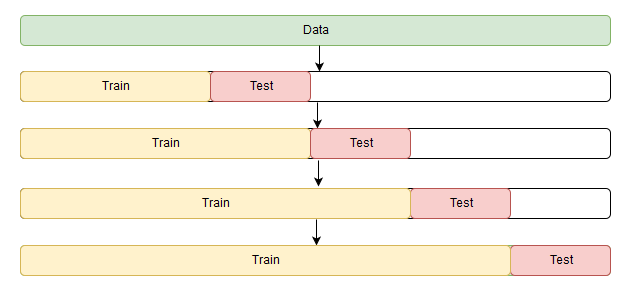

При использовании стратегии скользящего окна размер обучающей выборки остается незименным. Выборка последовательно сдвигается вправо вслед за тестовой выборкой, при этом начало временного ряда ни в обучении модели, ни в тестировании участия не принимает.

В библиотеке sktime кросс-валидация временных рядов реализована с помощью функции evaluate(), принимающей на вход следующие основные параметры:

* forecaster - алгоритм предсказания (любой реализованный в sktime либо совместимый с sklearn);
* cv - стратегия кросс-валидации (например, расширяющееся окно ExpandingWindowSplitter());
* y - временной ряд
* return_data - возвращать дата-фрейм с расширенными данными


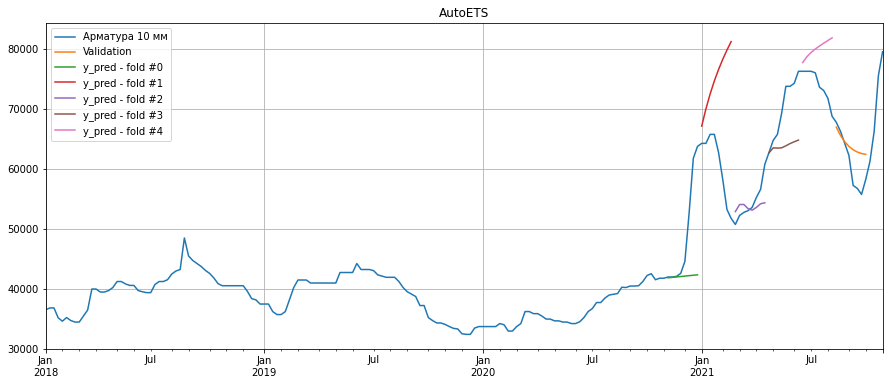

Срендняя sMAPE на кросс-валидации AutoETS: 11.04%
Срендняя sMAPE на валидационной выборке AutoETS: 5.68%
Модель недообучена, так как ошибка на тестовой выборке (11.04%) превышает ошибку на валидационной выборке (5.68%) более, чем на 10%


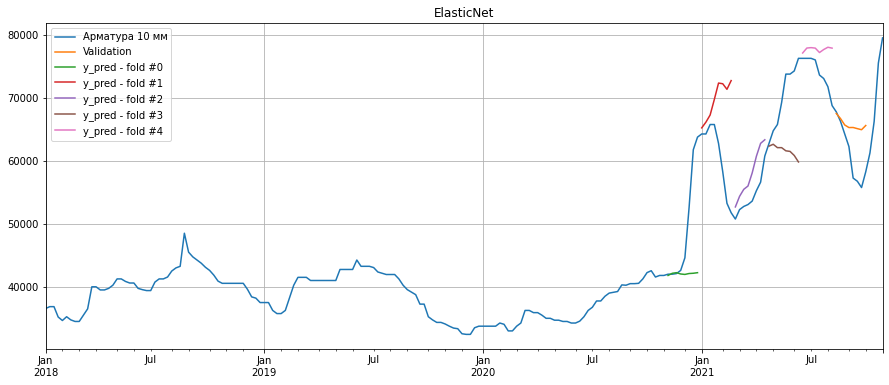

Срендняя sMAPE на кросс-валидации ElasticNet: 10.26%
Срендняя sMAPE на валидационной выборке ElasticNet: 8.24%
Модель недообучена, так как ошибка на тестовой выборке (10.26%) превышает ошибку на валидационной выборке (8.24%) более, чем на 10%


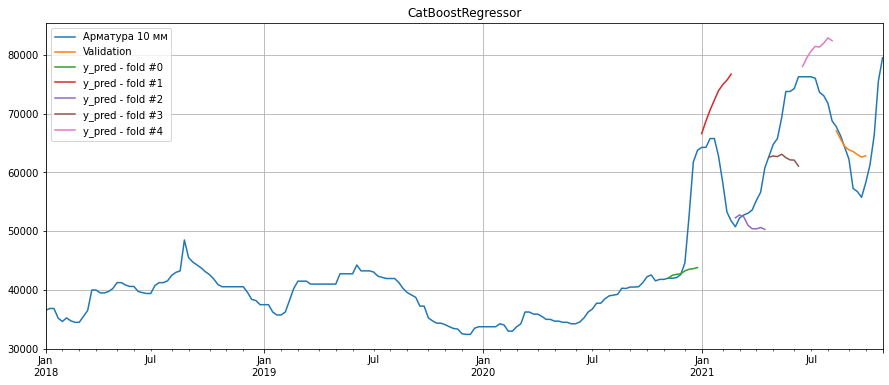

Срендняя sMAPE на кросс-валидации CatBoostRegressor: 11.39%
Срендняя sMAPE на валидационной выборке CatBoostRegressor: 5.86%
Модель недообучена, так как ошибка на тестовой выборке (11.39%) превышает ошибку на валидационной выборке (5.86%) более, чем на 10%


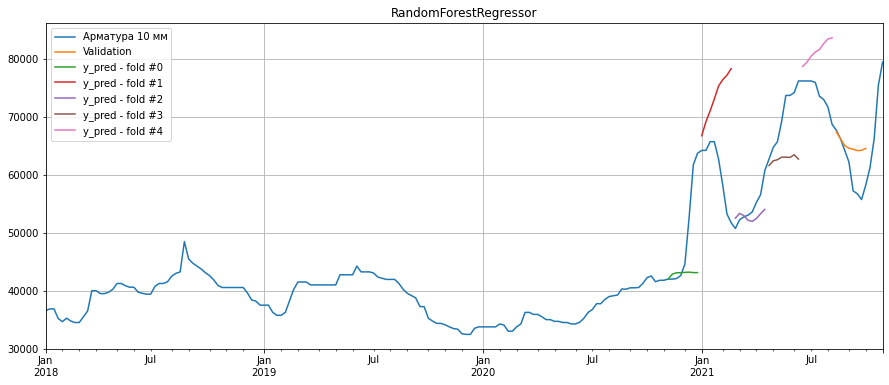

Срендняя sMAPE на кросс-валидации RandomForestRegressor: 11.30%
Срендняя sMAPE на валидационной выборке RandomForestRegressor: 7.19%
Модель недообучена, так как ошибка на тестовой выборке (11.30%) превышает ошибку на валидационной выборке (7.19%) более, чем на 10%


In [ ]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

cv_result = pd.DataFrame(columns=['Алгоритм', 'Горизонт', 'train', 'test'])

best_models = {
    'AutoETS': AutoETS(auto=True, sp=12, additive_only=True),
    'ElasticNet': make_reduction(ElasticNet(random_state=0), 
                                              window_length=12, 
                                              strategy="recursive"),
    'CatBoostRegressor': make_reduction(catboost.CatBoostRegressor(l2_leaf_reg = 3, 
                                                                   n_estimators=2000, 
                                                                   learning_rate=0.05, 
                                                                   depth=6,
                                                                   silent=True), 
                                                                   window_length=12, 
                                                                   strategy="recursive",
                                                                   scitype='tabular-regressor'),
     'RandomForestRegressor': make_reduction(RandomForestRegressor(random_state=0), 
                                                                   window_length=12, 
                                                                   strategy="recursive")
}
cv_steps = 5
cv_step_length = len(fhs[-2])
cv_initial_window = len(df_metall_imputed[:-len(fhs[-1])]) - cv_step_length * cv_steps
df_metall_cv_train_test = df_metall_imputed[:-len(fhs[-1])]
df_metall_cv_valid = df_metall_imputed[-len(fhs[-1]):]

for forecaster_name in best_models:
    forecaster = best_models[forecaster_name]
    model = TransformedTargetForecaster(steps=[("differencer", Differencer()),
                                               ("detrender", Detrender(forecaster=TBATS())),
                                               ("forecaster", forecaster)])
    model.fit(df_metall_imputed[:-len(fhs[-1])])
    y_preds = model.predict(fhs[-2])
    
    cv = ExpandingWindowSplitter(initial_window=cv_initial_window,
                             step_length=cv_step_length,
                             fh=fhs[-2])
    results = evaluate(forecaster=model, y=df_metall_cv_train_test, cv=cv, return_data=True)

    df_metall_imputed.plot(title=forecaster_name)
    y_preds.plot(label='Validation')
    j=0
    for i in results.y_pred:
      i.plot(figsize=(15,6), grid=True, label=f'y_pred - fold #{j}')
      j=j+1
    plt.legend()
    plt.show()
    
    cv_smape = results.test_MeanAbsolutePercentageError.mean()*100
    valid_smape = mape(df_metall_cv_valid[:len(fhs[-2])], y_preds)*100

    cv_result = cv_result.append(pd.DataFrame(columns=['Алгоритм', 'Горизонт', 'train', 'test'],
                                              data=[[forecaster_name,
                                                    cv_step_length,
                                                    f'{cv_smape:.2f}%',
                                                    f'{valid_smape:.2f}%']]))
    
    print(f'Срендняя sMAPE на кросс-валидации {forecaster_name}: {cv_smape:.2f}%')
    print(f'Срендняя sMAPE на валидационной выборке {forecaster_name}: {valid_smape:.2f}%')
    if valid_smape >= cv_smape * 1.1:
      print(f'Модель переобучена, так как ошибка на валидационной выборке ({valid_smape:.2f}%) превышает ошибку на тестовой выборке ({cv_smape:.2f}%) более, чем на 10%')
    elif valid_smape <= cv_smape / 1.1:
      print(f'Модель недообучена, так как ошибка на тестовой выборке ({cv_smape:.2f}%) превышает ошибку на валидационной выборке ({valid_smape:.2f}%) более, чем на 10%')
    else:
      print(f'Модель обучена корректна, так как разница между ошибками на тестовой ({cv_smape:.2f}%) и валидационной выборках ({valid_smape:.2f}%) не превышает 10%')

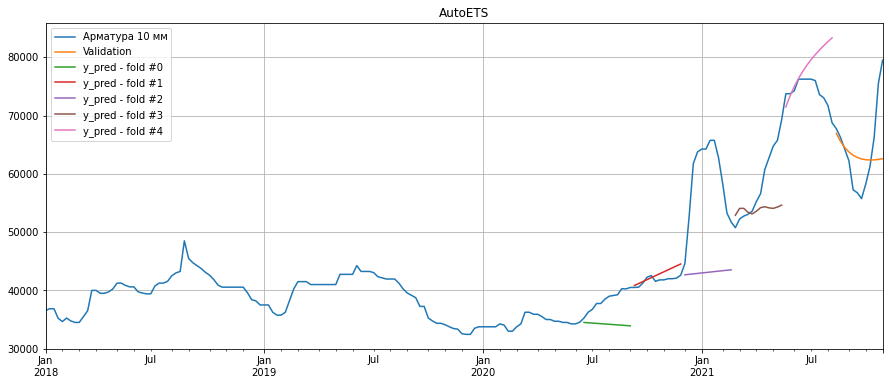

Срендняя sMAPE на кросс-валидации AutoETS: 11.88%
Срендняя sMAPE на валидационной выборке AutoETS: 7.64%
Модель недообучена, так как ошибка на тестовой выборке (11.88%) превышает ошибку на валидационной выборке (7.64%) более, чем на 10%


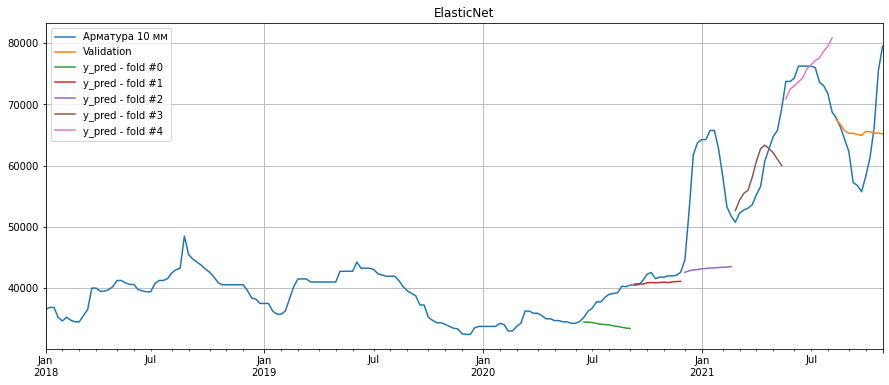

Срендняя sMAPE на кросс-валидации ElasticNet: 11.11%
Срендняя sMAPE на валидационной выборке ElasticNet: 8.82%
Модель недообучена, так как ошибка на тестовой выборке (11.11%) превышает ошибку на валидационной выборке (8.82%) более, чем на 10%


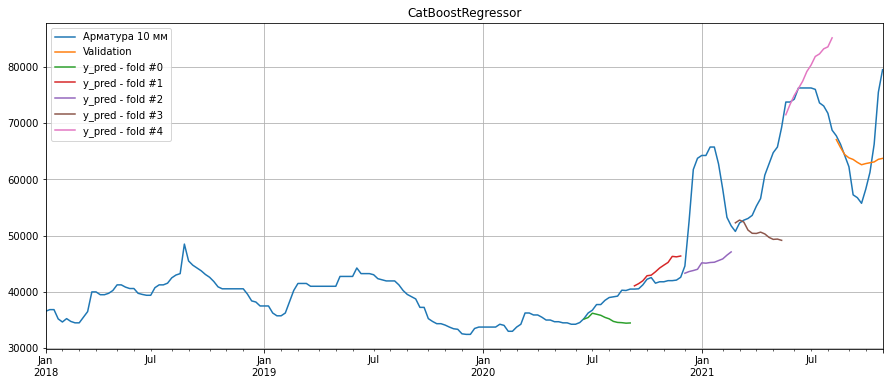

Срендняя sMAPE на кросс-валидации CatBoostRegressor: 12.13%
Срендняя sMAPE на валидационной выборке CatBoostRegressor: 7.50%
Модель недообучена, так как ошибка на тестовой выборке (12.13%) превышает ошибку на валидационной выборке (7.50%) более, чем на 10%


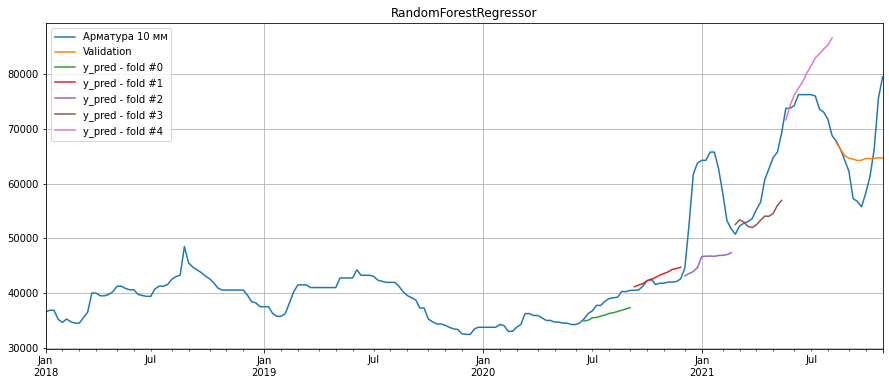

Срендняя sMAPE на кросс-валидации RandomForestRegressor: 10.04%
Срендняя sMAPE на валидационной выборке RandomForestRegressor: 8.19%
Модель недообучена, так как ошибка на тестовой выборке (10.04%) превышает ошибку на валидационной выборке (8.19%) более, чем на 10%


In [ ]:
cv_step_length = len(fhs[-1])
cv_initial_window = len(df_metall_imputed[:-len(fhs[-1])]) - cv_step_length * cv_steps
df_metall_cv_train_test = df_metall_imputed[:-len(fhs[-1])]
df_metall_cv_valid = df_metall_imputed[-len(fhs[-1]):]

for forecaster_name in best_models:
    forecaster = best_models[forecaster_name]
    model = TransformedTargetForecaster(steps=[("differencer", Differencer()),
                                               ("detrender", Detrender(forecaster=TBATS())),
                                               ("forecaster", forecaster)])
    model.fit(df_metall_imputed[:-len(fhs[-1])])
    y_preds = model.predict(fhs[-1])
    
    cv = ExpandingWindowSplitter(initial_window=cv_initial_window,
                             step_length=cv_step_length,
                             fh=fhs[-1])
    results = evaluate(forecaster=model, y=df_metall_cv_train_test, cv=cv, return_data=True)

    df_metall_imputed.plot(title=forecaster_name)
    y_preds.plot(label='Validation')
    j=0
    for i in results.y_pred:
      i.plot(figsize=(15,6), grid=True, label=f'y_pred - fold #{j}')
      j=j+1
    plt.legend()
    plt.show()
    
    cv_smape = results.test_MeanAbsolutePercentageError.mean()*100
    valid_smape = mape(df_metall_cv_valid[:len(fhs[-1])], y_preds)*100

    cv_result = cv_result.append(pd.DataFrame(columns=['Алгоритм', 'Горизонт', 'train', 'test'],
                                              data=[[forecaster_name,
                                                    cv_step_length,
                                                    f'{cv_smape:.2f}%',
                                                    f'{valid_smape:.2f}%']]))
    
    print(f'Срендняя sMAPE на кросс-валидации {forecaster_name}: {cv_smape:.2f}%')
    print(f'Срендняя sMAPE на валидационной выборке {forecaster_name}: {valid_smape:.2f}%')
    if valid_smape >= cv_smape * 1.1:
      print(f'Модель переобучена, так как ошибка на валидационной выборке ({valid_smape:.2f}%) превышает ошибку на тестовой выборке ({cv_smape:.2f}%) более, чем на 10%')
    elif valid_smape <= cv_smape / 1.1:
      print(f'Модель недообучена, так как ошибка на тестовой выборке ({cv_smape:.2f}%) превышает ошибку на валидационной выборке ({valid_smape:.2f}%) более, чем на 10%')
    else:
      print(f'Модель обучена корректна, так как разница между ошибками на тестовой ({cv_smape:.2f}%) и валидационной выборках ({valid_smape:.2f}%) не превышает 10%')

In [ ]:
results

,cutoff,fit_time,len_train_window,pred_time,test_MeanAbsolutePercentageError,y_pred,y_test,y_train
0,2020-06-08/2020-06-14,3.947073,128,0.125499,0.060457,2020-06-15/2020-06-21 34885.207242 2020-06-...,2020-06-15/2020-06-21 35250.0 2020-06-22/20...,2018-01-01/2018-01-07 36550.0 2018-01-08/20...
1,2020-08-31/2020-09-06,5.967440,140,0.122071,0.029924,2020-09-07/2020-09-13 41157.417602 2020-09-...,2020-09-07/2020-09-13 40500.0 2020-09-14/20...,2018-01-01/2018-01-07 36550.0 2018-01-08/20...
2,2020-11-23/2020-11-29,5.657356,152,0.128537,0.244813,2020-11-30/2020-12-06 43130.034054 2020-12-...,2020-11-30/2020-12-06 44600.0 2020-12-07/20...,2018-01-01/2018-01-07 36550.0 2018-01-08/20...
3,2021-02-15/2021-02-21,27.217282,164,0.120456,0.084259,2021-02-22/2021-02-28 52533.719865 2021-03-...,2021-02-22/2021-02-28 50750.0 2021-03-01/20...,2018-01-01/2018-01-07 36550.0 2018-01-08/20...
4,2021-05-10/2021-05-16,34.468980,176,0.128133,0.082426,2021-05-17/2021-05-23 71642.029244 2021-05-...,2021-05-17/2021-05-23 73750.0 2021-05-24/20...,2018-01-01/2018-01-07 36550.0 2018-01-08/20...


In [ ]:
pd.pivot_table(cv_result[cv_result['Горизонт']==8],
               index=["Алгоритм"],
               values=['train', 'test'],
               columns=['Горизонт'],
               aggfunc='sum')

,test,train
Горизонт,8,8
Алгоритм,,
AutoETS,5.68%,11.04%
CatBoostRegressor,5.86%,11.39%
ElasticNet,8.24%,10.26%
RandomForestRegressor,7.19%,11.30%


In [ ]:
pd.pivot_table(cv_result[cv_result['Горизонт']==12],
               index=["Алгоритм"],
               values=['train', 'test'],
               columns=['Горизонт'],
               aggfunc='sum')

,test,train
Горизонт,12,12
Алгоритм,,
AutoETS,7.64%,11.88%
CatBoostRegressor,7.50%,12.13%
ElasticNet,8.82%,11.11%
RandomForestRegressor,8.19%,10.04%


рекурентные нейронные сети для анализа временных рядов

https://habr.com/ru/post/495884/

https://habr.com/ru/post/505338/



определение структурного сдвига:
* https://en.wikipedia.org/wiki/Structural_break
* Тесто Чоу (https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%A7%D0%BE%D1%83, https://github.com/jtloong/chow_test, https://joshualoong.com/2018/01/05/Building-the-Python-chow-test-Package/)
* Тест Вальда (https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%92%D0%B0%D0%BB%D1%8C%D0%B4%D0%B0)
* Тест отношения правдоподобия (https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%BE%D1%82%D0%BD%D0%BE%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BF%D1%80%D0%B0%D0%B2%D0%B4%D0%BE%D0%BF%D0%BE%D0%B4%D0%BE%D0%B1%D0%B8%D1%8F)